### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

# cutoff to filter out "dummy regressor" over-regularized models
# these can deflate performance around feature count 0, which can inflate correlations,
# set to None for no cutoff
quantile_cutoff = 0.01

# 'aupr' or 'auroc'
metric = 'aupr'

# 'pearson' or 'spearman'
correlation = 'spearman'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(22200, 6)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,UCEC,0.0025,42,0,5700
1,MAP3K1,UCEC,0.0025,42,1,5878
2,MAP3K1,UCEC,0.0025,42,2,4785
3,MAP3K1,UCEC,0.0025,42,3,5396
4,MAP3K1,BRCA,0.0001,1,0,7919


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(66600, 10)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.99956,0.993810,MAP3K1,BRCA,signal,1,train,0,all_other_cancers,0.0025
1,0.47505,0.072132,MAP3K1,BRCA,signal,1,test,0,all_other_cancers,0.0025
2,0.50840,0.061408,MAP3K1,BRCA,signal,1,cv,0,all_other_cancers,0.0025
3,0.99648,0.942830,MAP3K1,BRCA,signal,1,train,1,all_other_cancers,0.0025
4,0.46982,0.100750,MAP3K1,BRCA,signal,1,test,1,all_other_cancers,0.0025


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,MAP3K1,UCEC,0.0025,42,0,5700,0.99901,0.991220,train,all_other_cancers
1,MAP3K1,UCEC,0.0025,42,0,5700,0.45098,0.041307,test,all_other_cancers
2,MAP3K1,UCEC,0.0025,42,0,5700,0.70346,0.266920,cv,all_other_cancers
3,MAP3K1,UCEC,0.0025,42,1,5878,0.99483,0.953730,train,all_other_cancers
4,MAP3K1,UCEC,0.0025,42,1,5878,0.46833,0.060331,test,all_other_cancers


cutoff: 5.0


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
51939,ATM,LUAD,0.1,1,1,0,0.50000,0.077099,train,all_other_cancers
51940,ATM,LUAD,0.1,1,1,0,0.50000,0.059322,test,all_other_cancers
51941,ATM,LUAD,0.1,1,1,0,0.50000,0.086758,cv,all_other_cancers
52731,ATM,PRAD,0.1,42,1,1,0.51645,0.107460,train,all_other_cancers
52732,ATM,PRAD,0.1,42,1,1,0.43739,0.042122,test,all_other_cancers
46965,PIK3CA,LUSC,0.1,1,3,1,0.63624,0.386820,train,all_other_cancers
46966,PIK3CA,LUSC,0.1,1,3,1,0.47409,0.395190,test,all_other_cancers
13094,CDKN2A,SARC,0.1,42,0,1,0.45874,0.304710,cv,all_other_cancers


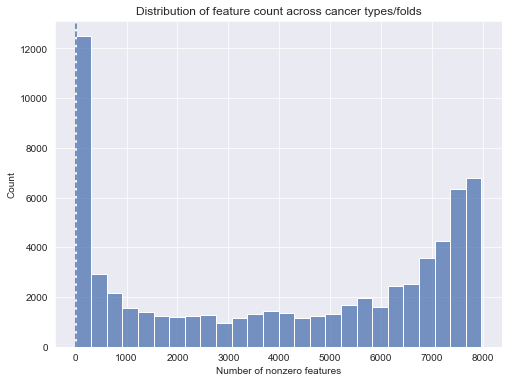

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
if quantile_cutoff is not None:
    nz_coefs_cutoff = coefs_perf_df.nz_coefs.quantile(q=0.01)
    plt.gca().axvline(nz_coefs_cutoff, linestyle='--')
    print('cutoff:', nz_coefs_cutoff)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

coefs_perf_df.loc[coefs_perf_df.nz_coefs.sort_values()[:8].index, :]

In [7]:
# look at correlation for each cancer type individually                                               
# positive correlation => more features, better performance                                           
corr_cancer_type_df = []                                                                              
                                                                                                      
if quantile_cutoff is not None:                                                                       
    coefs_perf_df = coefs_perf_df[coefs_perf_df.nz_coefs > nz_coefs_cutoff].copy()                    
                                                                                                      
for gene in coefs_perf_df.gene.unique():                                                              
    for cancer_type in coefs_perf_df.holdout_cancer_type.unique():                                    
        corr_df = coefs_perf_df[                                                                      
            (coefs_perf_df.gene == gene) &                                                            
            (coefs_perf_df.holdout_cancer_type == cancer_type) &                                      
            (coefs_perf_df.data_type == 'test')                                                       
        ]                                                                                             
        try:                                                                                          
            if correlation == 'pearson':
                r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)                             
            elif correlation == 'spearman':
                r, p = spearmanr(corr_df.nz_coefs.values, corr_df.aupr.values)                             
            else:
                raise NotImplementedError
        except ValueError:                                                                            
            # this happens when the model wasn't trained on the cancer type                           
            # for the given gene, just skip                                                           
            continue                                                                                  
        corr_cancer_type_df.append(                                                                   
            [gene, cancer_type, r, p]                                                                 
        )                                                                                             
                                                                                                      
corr_column = f'{correlation}_r'
pval_column = f'{correlation}_pval'
corr_cancer_type_df = pd.DataFrame(                                                                   
    corr_cancer_type_df,                                                                              
    columns=['gene', 'cancer_type', corr_column, pval_column]                                      
).sort_values(by=corr_column, ascending=False)                                                        
                                                                                                      
print(corr_cancer_type_df.shape)                                                                      
corr_cancer_type_df.head()

(1568, 4)


,gene,cancer_type,spearman_r,spearman_pval
1454,SETD2,KIRC,0.744082,2.603879e-15
480,ARID1A,STAD,0.744063,2.610411e-15
47,TP53,PAAD,0.729769,3.480716e-14
235,CDKN2A,GBM,0.710181,4.732157e-13
994,PTEN,LUSC,0.701875,4.078657e-13


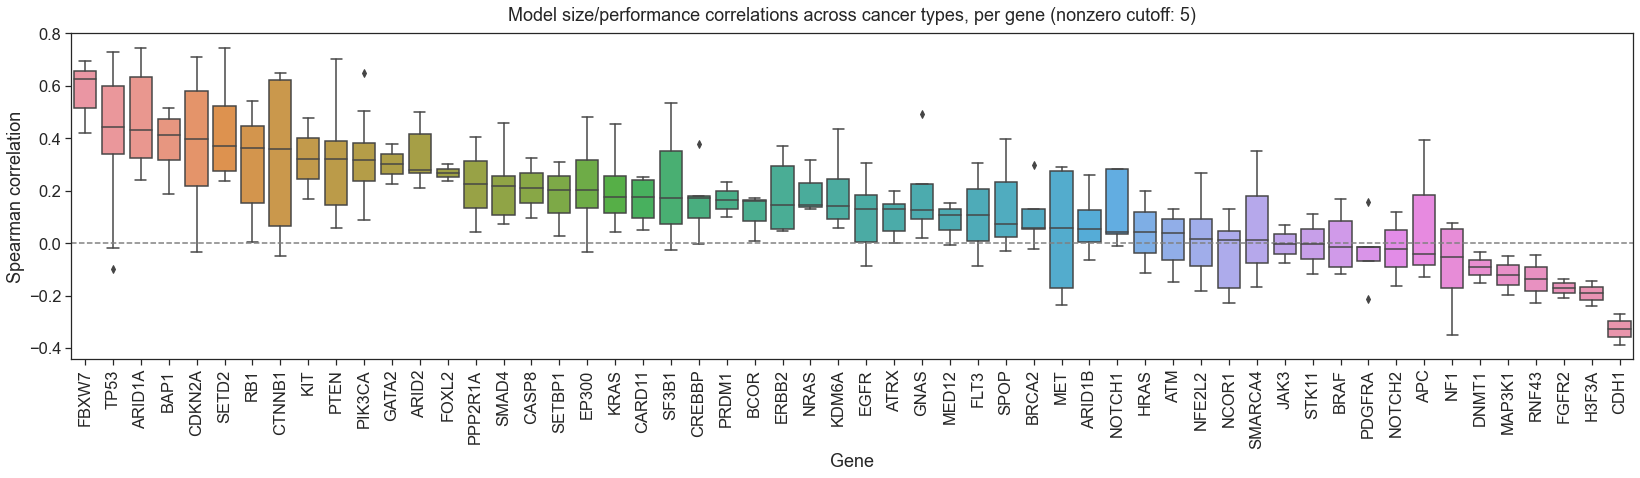

In [8]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median pearson per gene
gene_order = (corr_cancer_type_df
    .groupby('gene')
    .agg(np.median)
    .sort_values(by=corr_column, ascending=False)
).index.values

with sns.plotting_context('notebook', font_scale=1.5):
    ax = sns.boxplot(data=corr_cancer_type_df, order=gene_order, x='gene', y=corr_column)
    ax.axhline(0.0, linestyle='--', color='grey')
    plt.xticks(rotation=90)
    plt.title(f'Model size/performance correlations across cancer types, per gene (nonzero cutoff: {nz_coefs_cutoff:.0f})', y=1.02)
    plt.xlabel('Gene')
    plt.ylabel(f'{correlation.capitalize()} correlation')

In [9]:
mean_corr_gene_df = (corr_cancer_type_df
    .groupby('gene')
    .agg(np.mean)
    .drop(columns=[pval_column])
)

mean_corr_gene_df.sort_values(by=corr_column, ascending=False).head()

,spearman_r
gene,
FBXW7,0.589849
ARID1A,0.475537
SETD2,0.430070
TP53,0.410045
BAP1,0.380757


In [10]:
mean_corr_gene_df.sort_values(by=corr_column, ascending=False).tail()

,spearman_r
gene,
MAP3K1,-0.122424
RNF43,-0.137594
FGFR2,-0.172024
H3F3A,-0.192096
CDH1,-0.327914


Mean of mean correlations: 0.1410


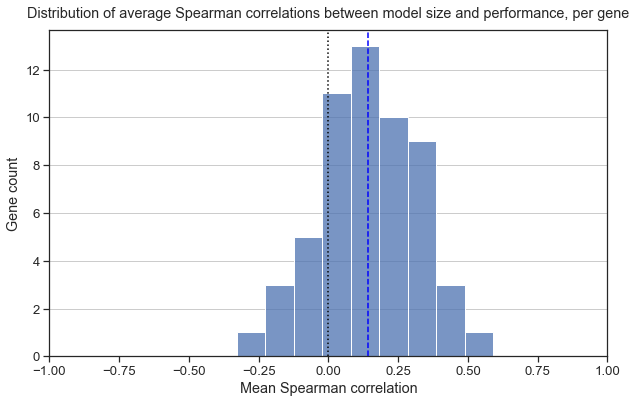

In [11]:
sns.set(style='ticks', rc={'figure.figsize': (10, 6), 'axes.grid': True, 'axes.grid.axis': 'y'})

with sns.plotting_context('notebook', font_scale=1.2):
    plt.xlim(-1.0, 1.0)
    sns.histplot(data=mean_corr_gene_df, x=corr_column)
    plt.axvline(0.0, linestyle=':', color='black')
    plt.axvline(mean_corr_gene_df[corr_column].mean(), linestyle='--', color='blue')
    plt.title(
        f'Distribution of average {correlation.capitalize()} correlations between model size and performance, per gene',
        y=1.02
    )
    plt.xlabel(f'Mean {correlation.capitalize()} correlation')
    plt.ylabel('Gene count')

print(f'Mean of mean correlations: {mean_corr_gene_df[corr_column].mean():.4f}')

In [12]:
mean_corr_cancer_type_df = (corr_cancer_type_df
    .groupby('cancer_type')
    .agg(np.mean)
    .drop(columns=[pval_column])
)

mean_corr_cancer_type_df.sort_values(by=corr_column, ascending=False).head()

,spearman_r
cancer_type,
KIRC,0.553335
UVM,0.533788
KICH,0.396280
KIRP,0.360167
UCS,0.345677


In [13]:
mean_corr_cancer_type_df.sort_values(by=corr_column, ascending=False).tail()

,spearman_r
cancer_type,
SKCM,0.114126
OV,0.110515
PCPG,0.082817
LGG,0.081057
THCA,0.031215


Mean of mean correlations: 0.2394


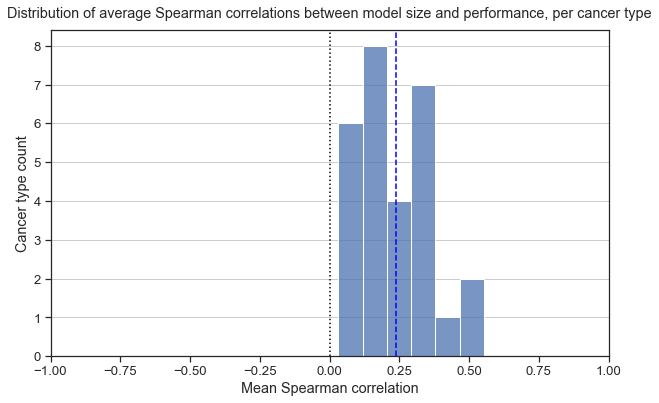

In [14]:
sns.set(style='ticks', rc={'figure.figsize': (10, 6), 'axes.grid': True, 'axes.grid.axis': 'y'})

with sns.plotting_context('notebook', font_scale=1.2):
    plt.xlim(-1.0, 1.0)
    sns.histplot(data=mean_corr_cancer_type_df, x=corr_column)
    plt.axvline(0.0, linestyle=':', color='black')
    plt.axvline(mean_corr_cancer_type_df[corr_column].mean(), linestyle='--', color='blue')
    plt.title(f'Distribution of average {correlation.capitalize()} correlations between model size and performance, per cancer type', y=1.02)
    plt.xlabel(f'Mean {correlation.capitalize()} correlation')
    plt.ylabel('Cancer type count')

print(f'Mean of mean correlations: {mean_corr_cancer_type_df[corr_column].mean():.4f}')